### Import the CNN Util and libraries needed
We have the util to make it easy to create and try new variations of the CNN model and be consistent with how we're analyzing and evaluating it.

In [2]:
# Import necessary libraries
import cnn_utils
from keras import layers, models, optimizers, callbacks
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, EfficientNetB0, VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import ResNet50V2

### Load the data

In [3]:
data_dict = cnn_utils.load_cifar10_from_tar()

CIFAR-10 tar file not found at cifar-10-python.tar
Download completed!
Loading CIFAR-10 data...
Loading training batch 1...
Loading training batch 2...
Loading training batch 3...
Loading training batch 4...
Loading training batch 5...
Loading test data...
Raw data loaded successfully!
Training data shape: (50000, 3072)
Test data shape: (10000, 3072)
Label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Preporcess the data

In [4]:
data = cnn_utils.preprocess_data(data_dict)

Preprocessing data...
Preprocessing completed!
Training: (45000, 32, 32, 3), Validation: (5000, 32, 32, 3), Test: (10000, 32, 32, 3)


### Let's do a quick visualization of sample images (to also ensure we still have the correct shape)

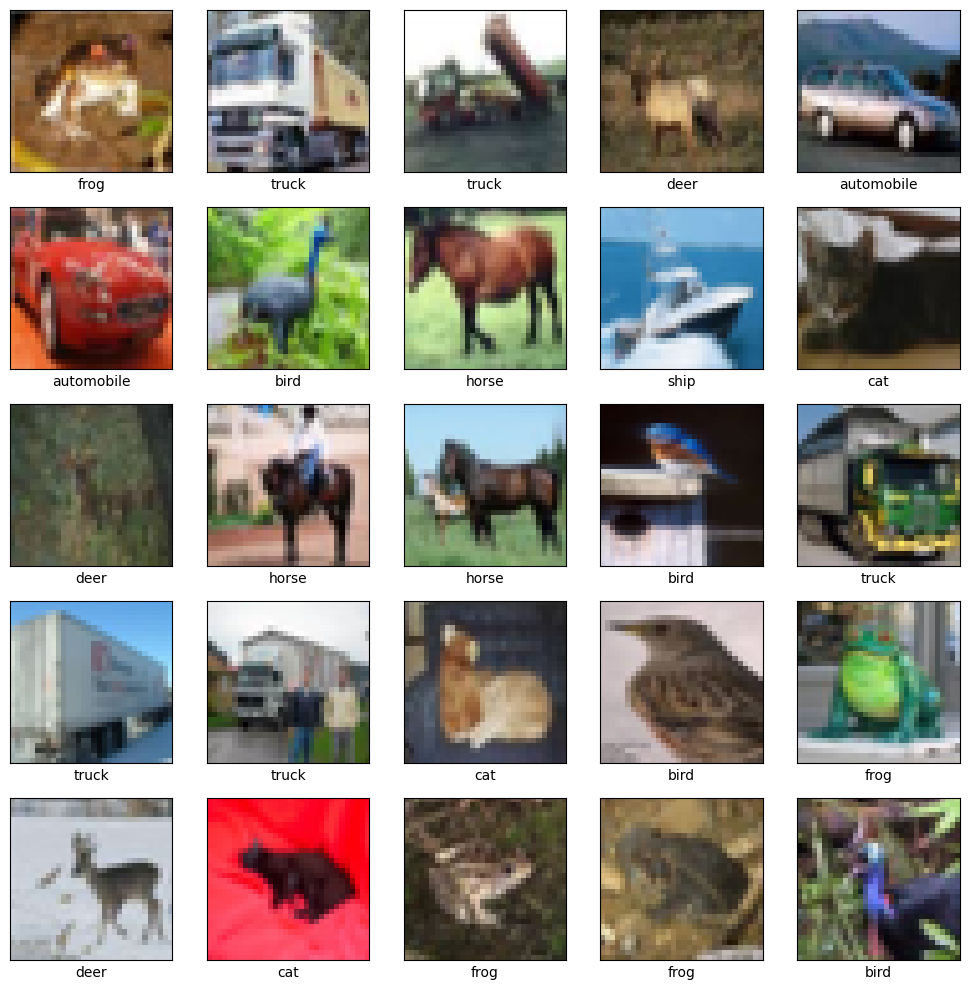

In [5]:
cnn_utils.visualize_data_samples(data)


### Data processing for Transfer Learning
- Converts back to [0, 255]: Your data was normalized to [0, 1], but ImageNet pre-trained models expect the original [0, 255] pixel range
- Applies ImageNet preprocessing: Uses preprocess_input() which applies model-specific normalization (e.g., ResNet uses different normalization than VGG)

In [6]:
def preprocess_for_transfer_learning(data):
    data['X_train'] = data['X_train'] * 255.0
    data['X_val'] = data['X_val'] * 255.0
    data['X_test'] = data['X_test'] * 255.0

    # Apply ImageNet preprocessing (model-specific normalization)
    data['X_train'] = preprocess_input(data['X_train'])
    data['X_val'] = preprocess_input(data['X_val'])
    data['X_test'] = preprocess_input(data['X_test'])

    return data

# Apply transfer learning preprocessing
data = preprocess_for_transfer_learning(data)
print("Data preprocessed for transfer learning")

Data preprocessed for transfer learning


### Data Augmentation

Moderate geometric augmentation that applies realistic transformations to training images:
- Rotation (±15°), shifting (10% in each direction), and zooming (±10%) simulate natural camera angle and distance variations
- Horizontal flipping doubles the dataset by creating mirror images (works well for CIFAR-10 since objects like cars/planes look realistic when flipped)


In [7]:
def create_augmentation():
    return ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )

augmentation = create_augmentation()
augmentation.fit(data['X_train'])

### Let's define our CNN model (architecture)
Deeper, more sophisticated architecture for higher accuracy
Structure:
- 3 convolutional blocks (64→128→256 filters)
- BatchNormalization after each conv layer
- Progressive dropout (0.3→0.4→0.5)
- Large dense layer (512 neurons)

### Create transfer model

In [8]:
def create_transfer_model(base_model_name='resnet50', num_classes=10):
    """
    Create transfer learning model with frozen base and custom classifier
    """
    # Choose base model
    if base_model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    elif base_model_name == 'efficientnet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    elif base_model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    elif base_model_name == 'resnet50v2':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Freeze the base model
    base_model.trainable = False

    # Build the complete model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

# Create the model
model, base_model = create_transfer_model('resnet50v2')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_utils.print_model_summary(model)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 1, 1, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,837,066 (90.93 MB)

 Trainable params: 267,914 (1.02 MB)

 Non-trainable params: 23,569,152 (89.91 MB)


📊 Total Parameters: 23,837,066


### Phase 1 Training (Frozen Base)


In [9]:
print("=== PHASE 1: Training classifier with frozen base ===")
# Train with frozen base model
history_phase1 = cnn_utils.train_model(
    model,
    data,
    augmentation=augmentation,
    epochs=20,
    batch_size=32
)


=== PHASE 1: Training classifier with frozen base ===
Starting model training...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 49s 25ms/step - accuracy: 0.1985 - loss: 2.3882 - val_accuracy: 0.3152 - val_loss: 1.9457
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.2505 - loss: 2.0473 - val_accuracy: 0.3220 - val_loss: 1.9025
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.2745 - loss: 1.9985 - val_accuracy: 0.3292 - val_loss: 1.8964
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.2805 - loss: 1.9854 - val_accuracy: 0.3174 - val_loss: 1.9147
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.2763 - loss: 1.9801 - val_accuracy: 0.3422 - val_loss: 1.8845
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.2873 - loss: 1.9633 - val_accuracy: 0.3402 - val_loss: 1.8696
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.2838 - loss: 1.9700 - val_accuracy: 0.3390 - val_loss: 1.8740
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.2890 - loss: 1.95

### Phase 2 Training (Fine-tuning)

In [10]:
print("=== PHASE 2: Fine-tuning with unfrozen base ===")

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Much lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
history_phase2 = cnn_utils.train_model(
    model,
    data,
    augmentation=augmentation,
    epochs=30,
    batch_size=32
)

=== PHASE 2: Fine-tuning with unfrozen base ===
Starting model training...
Epoch 1/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 110s 44ms/step - accuracy: 0.1340 - loss: 2.4284 - val_accuracy: 0.1808 - val_loss: 2.4677
Epoch 2/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.1771 - loss: 2.2298 - val_accuracy: 0.2318 - val_loss: 2.5065
Epoch 3/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.2169 - loss: 2.1054 - val_accuracy: 0.2706 - val_loss: 2.1597
Epoch 4/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.2441 - loss: 2.0184 - val_accuracy: 0.2954 - val_loss: 2.0377
Epoch 5/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.2692 - loss: 1.9430 - val_accuracy: 0.3350 - val_loss: 2.0257
Epoch 6/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.3005 - loss: 1.8690 - val_accuracy: 0.3642 - val_loss: 1.8433
Epoch 7/30
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - accuracy: 0.3275 - loss: 1.8165 - val_accuracy: 0.4016 - val_loss: 1.7260


### Combined History

In [11]:
# Combine training histories for complete visualization
def combine_histories(hist1, hist2):
    """Combine two training histories"""
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]

    # Create a mock history object
    class CombinedHistory:
        def __init__(self, history_dict):
            self.history = history_dict

    return CombinedHistory(combined)

# Combine both training phases
combined_history = combine_histories(history_phase1, history_phase2)

### Let's show the evaluation result

MODEL EVALUATION


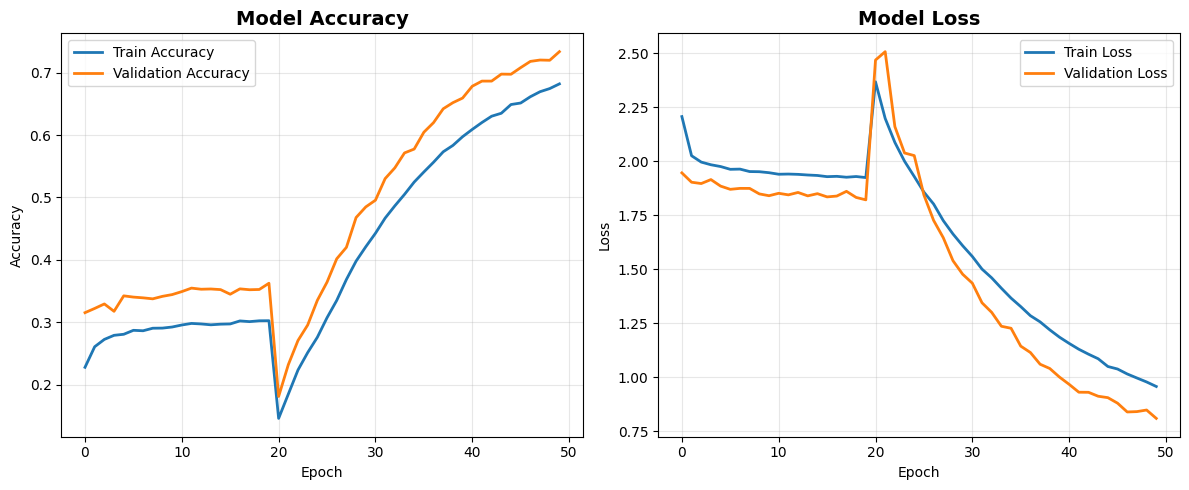


🎯 Final Test Results:
   Test Accuracy: 0.7311
   Test Loss: 0.8189

📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.78      0.83      0.80      1000
  automobile       0.78      0.86      0.82      1000
        bird       0.76      0.61      0.67      1000
         cat       0.62      0.46      0.53      1000
        deer       0.70      0.64      0.67      1000
         dog       0.71      0.57      0.63      1000
        frog       0.63      0.84      0.72      1000
       horse       0.72      0.84      0.78      1000
        ship       0.87      0.80      0.84      1000
       truck       0.75      0.86      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



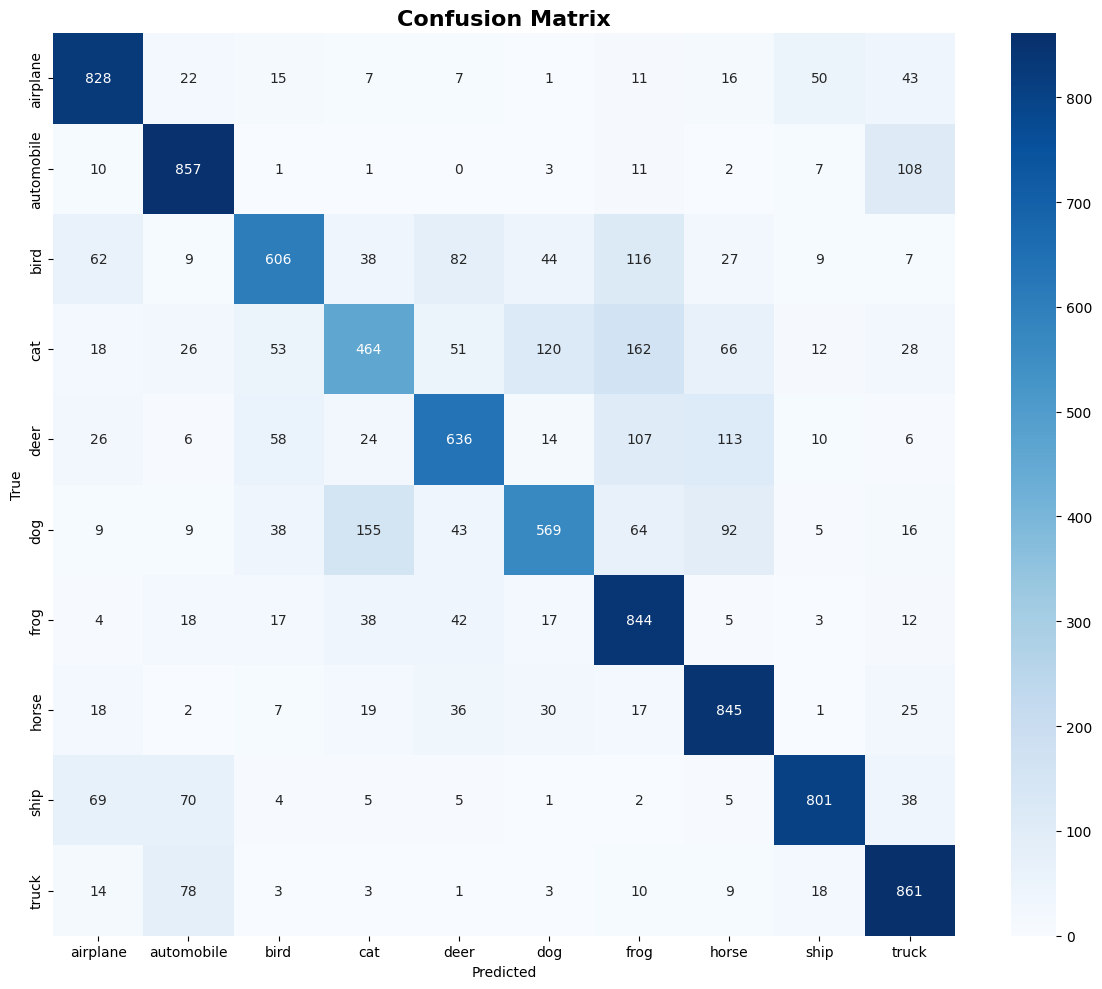

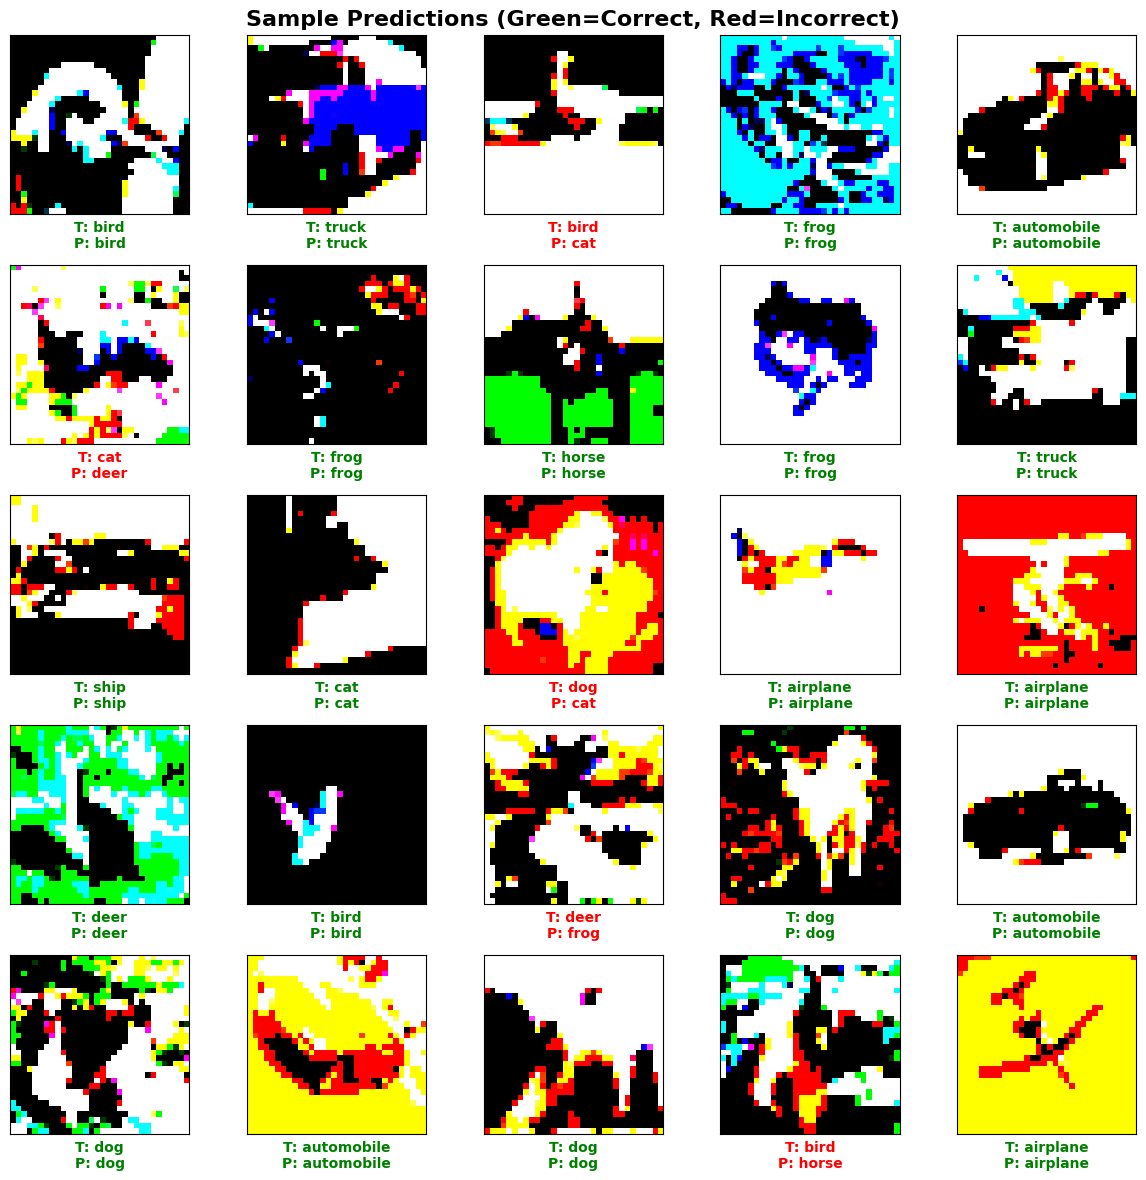

In [12]:
cnn_utils.evaluate_model(model, data, combined_history)